## Boiler Plate:

In [1]:
# Boiler plate:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Behind the scenes code:
import dreply_BMWit_source as dreply

# Tools used:
import pandas as pd # DataFrames
import numpy as np # Numerical Package
import matplotlib.pylab as plt # Plotting Tools

# Display option:
pd.set_option('display.max_rows', 500)

## What data are we analzing?
* We wanted to demonstrate data science on a BMW Carmen UK CRM dataset but were unable to procure that data
* Here, we analyze a dataset of **Warranty Claims in the USA between 2009 and 2012**
* Time permitting, demo will include topic recognition from scraped BMW forum data from [www.bimmerfest.com](www.bimmerfest.com)

## Parse and Load Warranty Claims Dataset
Libraries: Pandas, Regular Expressions

In [2]:
df = dreply.parse_and_load('../data/claims_full.txt')
df.head(3)

,pCLAIM_DEALER_GEOCODE,CLAIM_AGE_BUCKET,CLAIM_DEALER,CLAIM_DEALER_STATEPROVINCE,CLAIM_DATE,CLAIM_LABOR_CODE,CLAIM_LABOR_DESC,CLAIM_MONTH,CLAIM_PERIOD,CLAIM_QUARTER,...,pPART_HIST_COUNT,pPART_OPTIONS,pPART_PREVIOUSHIST,pPART_PREVIOUSHIST2,pPART_PREVIOUSHIST3,pPART_PREVIOUSHIST4,pPART_PREVIOUSHIST5,pVEH_EXPOSURE,pVEH_FLOAT,Days_In_Service
0,NaN,0 - 30 Days,NICHOLS DODGE,NC,2011-05-23,NaN,NaN,05 - MAY,2011-05,Q2,...,1,&LZE#&LZ4.,"2003/05/29,p313J1RLSXXKJ-1241,p313OPK1QJ5CA-31...",NaN,NaN,NaN,NaN,294,264,30
1,42.193400 -75.884900,91 - 180 Days,COREY'S NORTHGATE FORD/MADZA,NY,2010-09-15,NaN,NaN,09 - SEP,2010-09,Q3,...,1,&LZ4.,"2003/05/29,p313J1RLSXXKJ-1241,p313OPK1QJ5CA-31...",NaN,NaN,NaN,NaN,104,239,12
2,39.066700 -77.599700,91 - 180 Days,"DULLES MOTORCARS ~ JEEP, KIA, AND SUBARU",VA,2010-11-22,NaN,NaN,11 - NOV,2010-11,Q4,...,1,&LS4.,"2004/03/01,p313P805IXCRB-1900,p313B26QCG3KA-10...",NaN,NaN,NaN,NaN,308,159,148


## What kind of data is here?:

In [3]:
dreply.summarize(df)

pCLAIM_DEALER_GEOCODE          object
CLAIM_DEALER                   object
CLAIM_DEALER_STATEPROVINCE     object
CLAIM_DATE                     object
CLAIM_LABOR_CODE               object
Commodity                      object
Complaint_Description          object
PROD_DATE                      object
Part_Number                    object
RecordID                       object
SALE_DATE                      object
Supplier_Location              object
Vehicle_Assembly_Plant         object
Vehicle_Float                  object
Vehicle_Make                   object
Vehicle_Manufacturer           object
Vehicle_Model                  object
Vehicle_Model_Year              int64
pCLAIM_AGE_BUCKET             float64
pCLAIM_ODMTR_MILEAGE            int64
pCLAIM_TOT_GLOBL_AMT          float64
Days_In_Service                 int64
dtype: object

## Traditional Data Analysis and Visualization with Structured Data:
Some tools include:
* Tableau
* QLik
* Oracle - big data discovery
* **Python** - matplotlib, seaborn, *etc.*
* R - ggplot

## A Few Basic Drill Downs
#### This is the type of stuff that business analysts can already do easily with structured data

## Example 1: Number of Claims by Year:

In [25]:
df1 = df.groupby(['CLAIM_YEAR','Vehicle_Assembly_Plant']).apply(lambda x: len(x))
df1

CLAIM_YEAR  Vehicle_Assembly_Plant       
2009        Detroit, Mi, United States         43
            Lexington, Ky, United States       57
            Rockford, Il, United States        55
            Seoul, Korea                     1100
2010        Detroit, Mi, United States         75
            Lexington, Ky, United States       77
            Louisville, Ky, United States     444
            Rockford, Il, United States        77
            Seoul, Korea                      248
            Tokyo, Japan                      433
2011        Louisville, Ky, United States      13
            Tokyo, Japan                       14
dtype: int64

## Example 2: Claims in 2012 by Vehicle Make:

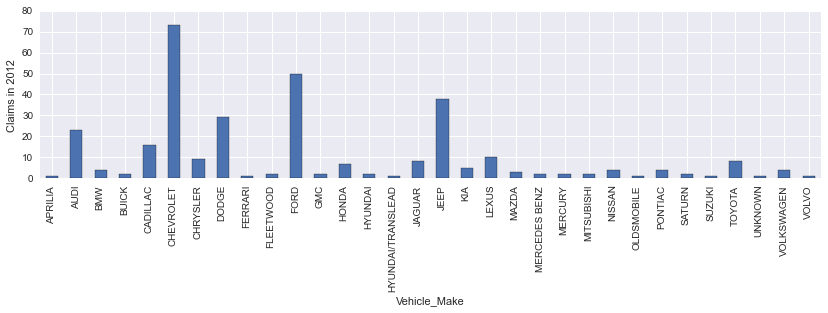

In [5]:
df1[2012].plot('bar', figsize=(14,3))
plt.ylabel('Claims in 2012')

## Example 3: BMW Claims Time Series:

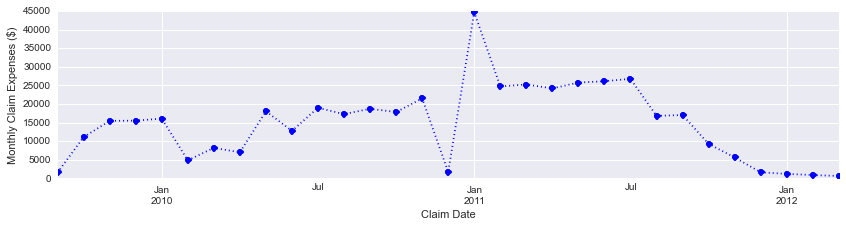

In [6]:
df['cdate'] = pd.to_datetime(df.CLAIM_DATE) # claim date column
(df[df.Vehicle_Make=='BMW']
    .set_index('cdate')
    .pCLAIM_TOT_GLOBL_AMT
    .resample('M', how='sum')
    .plot(style='b:', marker='o', figsize=(14,3))
)
plt.xlabel('Claim Date'); plt.ylabel('Monthly Claim Expenses ($)')

## Example 4: Top 10 BMW Claim Reasons:

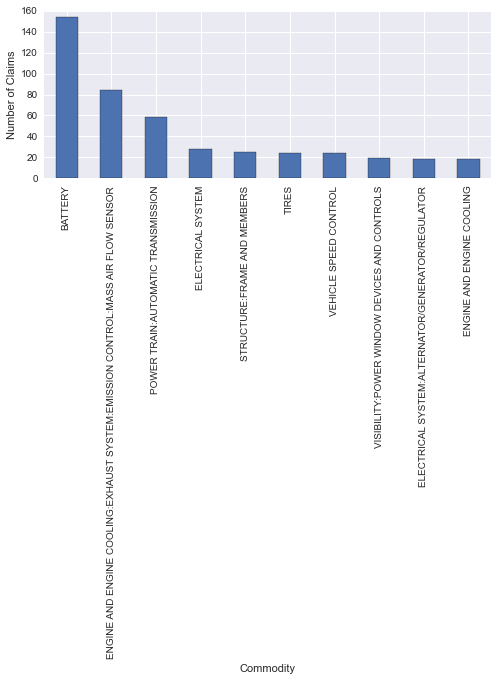

In [7]:
(df.groupby(['Vehicle_Make','Commodity'])
 .apply(lambda x: len(x))['BMW']
 .order(ascending=False)[:10]
 .plot('bar', figsize=(8,3))
)
plt.ylabel('Number of Claims')

## Why not build a claim value predictor?
* On what variables does claim value depend upon?
* **Train model to estimate the dollar value of a claim based variables discovered above**

## Before model "feature selection," we need to first transform data:
* Most datatypes are categorical and need to be vectorized

In [8]:
df, covariates, state_to_reg_series, makes = dreply.transform_vectorize(df)
df_BMW = df[df.Vehicle_Make=='BMW']

## Obviously Claim Value Depends On Claim Issue:

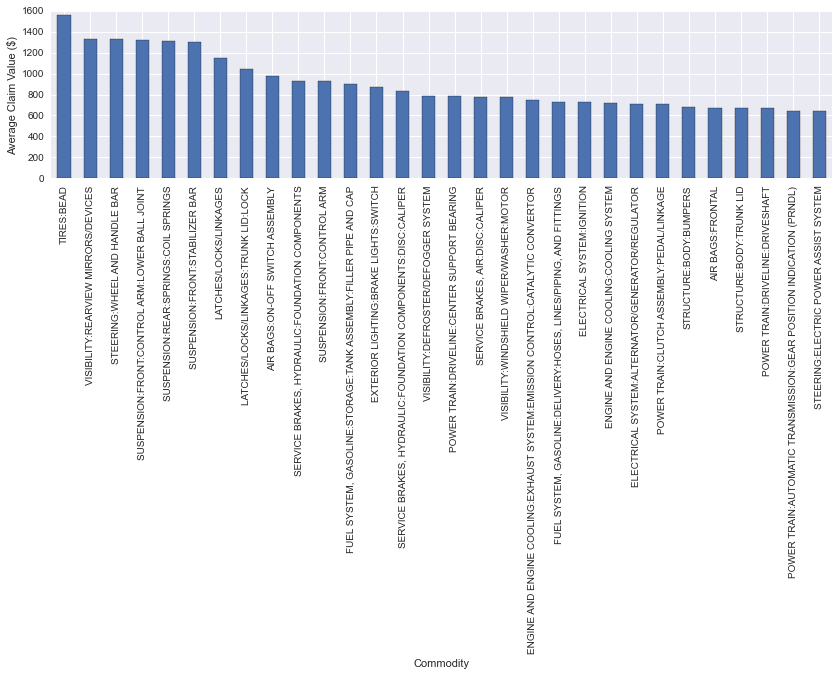

In [10]:
values = df_BMW.groupby('Commodity').mean()['pCLAIM_TOT_GLOBL_AMT'].sort(ascending=False, inplace=False)
values[:30].plot('bar', figsize=(14,3))
plt.ylabel('Average Claim Value ($)')

## Can We Predict Claim Expenses Based On Car Age and Type??
#### Let's look at the BMW models with the most claim data in order to make a prediction

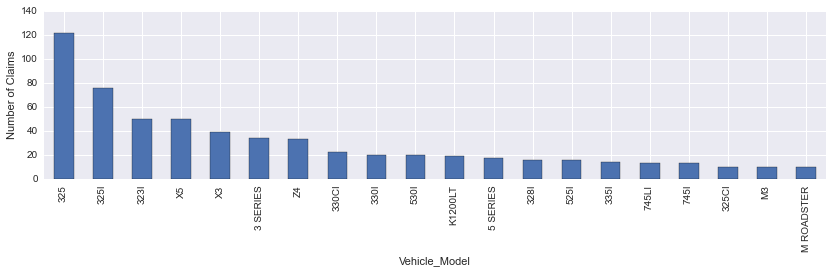

In [11]:
BMW_Claims = (df_BMW.groupby('Vehicle_Model')
              .apply(lambda x: len(x))
              .sort(inplace=False, ascending=False)
              )
BMW_Claims[:20].plot('bar', figsize=(14,3))
plt.ylabel('Number of Claims')

## Given enough data, one can predict the warrenty claim value over the age of the vehicle!

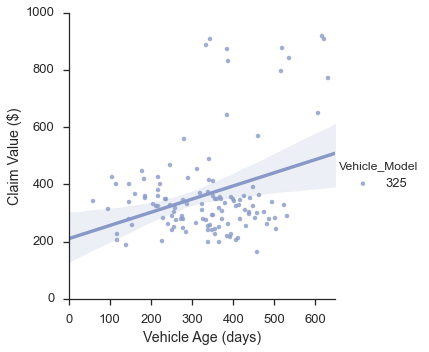

In [28]:
dreply.lmplot(df_BMW[df_BMW.Vehicle_Model.isin(BMW_Claims[0:1].index)], 
              size=5, xlim=(0,650), ylim=(0,1000))

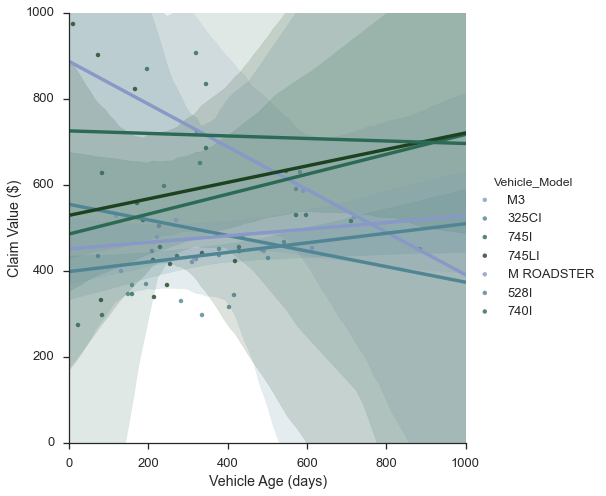

In [13]:
dreply.lmplot(df_BMW[df_BMW.Vehicle_Model.isin(BMW_Claims[15:22].index)], 
              size=7, xlim=(0,1000), ylim=(0,1000))

* Use these models to back-predict when particular problems are likely to occur next and get ahead of them
* Use these models to predict the expected lifetime warranty expenses by vehicle type
* Use these models to predict the warranty expenses of similar vehicles types

## Claim Frequency Over Warranty Lifetime (325):

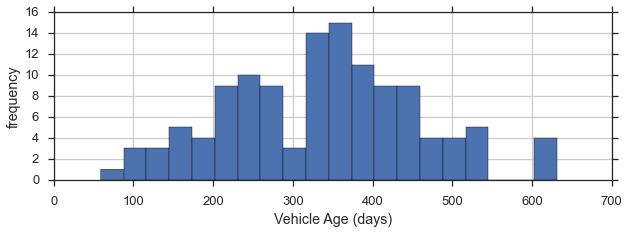

In [14]:
numBins = 20
(df_BMW[df_BMW.Vehicle_Model=='325']
     .v_age
     .hist(bins=numBins, figsize=(10,3))
)
plt.xlabel('Vehicle Age (days)'); plt.ylabel('frequency');

## Combine Claim Freq with Predicted Claim Value:

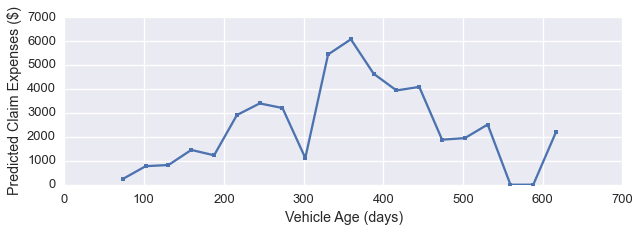

In [15]:
dreply.cost_prediction(np.histogram(df_BMW[df_BMW.Vehicle_Model=='325'].v_age, bins=numBins))

## Other Data Science:
### Cluster similar warranties together:
Example (Randomly Generated Data):

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


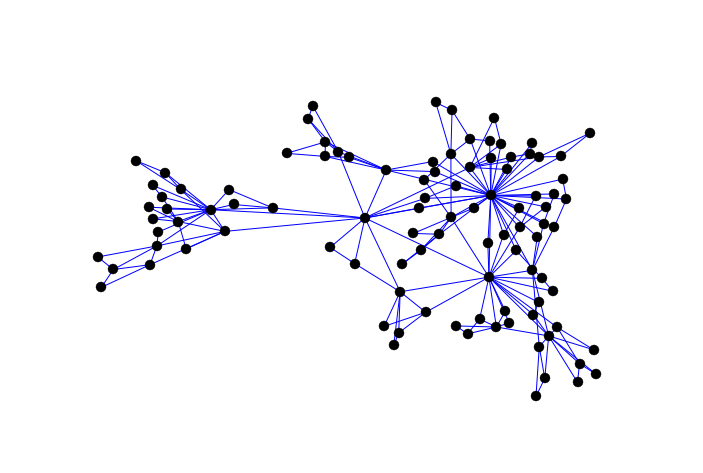

In [16]:
import networkx as nx
plt.figure(figsize=(9,6))
G = nx.powerlaw_cluster_graph(100,2,1)
nx.draw(G, node_color='k', node_size=100, edge_color='b')

## Geocoding:
#### One might be interested in knowing where certain claims tend to happen, to optimize response

* In the dataset, we have Dealer Geolocations (Lat,Lng) and US state
* Some US states missing, if we had those, we could map the data into US Federal regions:
![US Federal Regions](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/USFederalRegions.svg/220px-USFederalRegions.svg.png)

In [17]:
print "MISSING STATE-DATA:"
missing_geo_entries = (df.pCLAIM_DEALER_GEOCODE.notnull() &
                       df.CLAIM_DEALER_STATEPROVINCE.isnull())
df.ix[missing_geo_entries, ['pCLAIM_DEALER_GEOCODE', 'CLAIM_DEALER_STATEPROVINCE']].head(3)

MISSING STATE-DATA:


,pCLAIM_DEALER_GEOCODE,CLAIM_DEALER_STATEPROVINCE
1113,36.113100 -80.198300,NaN
4150,42.366300 -83.532500,NaN
27952,32.725300 -117.172100,NaN


## Reverse Geocode to Recover State:

In [18]:
df.ix[missing_geo_entries, 'pCLAIM_DEALER_GEOCODE'] = \
    df.ix[missing_geo_entries, 'pCLAIM_DEALER_GEOCODE'].map(dreply.reverseGEO)

(36.113100 -80.198300) --> north carolina
(42.366300 -83.532500) --> michigan
(32.725300 -117.172100) --> california
(26.908900 -82.043100) --> florida
(43.210300 -123.428600) --> oregon
(41.807800 -73.798100) --> new york
(39.526300 -119.812400) --> nevada
(36.173000 -115.123300) --> nevada
(39.622300 -75.726400) --> delaware
(29.469700 -98.529400) --> texas
(28.631800 -81.362500) --> florida
(39.138200 -77.186800) --> maryland


## What's around?  
#### Recommend a place for the customer to visit while waiting for repairs at dealer
Possible GET calls to:
* Yelp API
* Google Places API
* **Here Maps API**
* Foursquare API
* *etc.*

In [19]:
latlng = '36.153889 -95.992500'
nearby_places = dreply.places_nearby(latlng)
dreply.places_nearby_statement(nearby_places, closer_than=1000)

https://www.here.com/search/cafes?map=36.153889,-95.9925,16,normal
DEALER ADDRESS: 
183 W 2nd St S
Tulsa, OK 74103
USA

NEARBY LOCATIONS within 1000m:
1. 254m away, <here>, there is a theatre-music-culture (store)
2. 830m away, <here>, there is a theatre-music-culture (store)
3. 486m away, <here>, there is a restaurant (store)
4. 164m away, <here>, there is a theatre-music-culture (store)
5. 436m away, <here>, there is a coffee-tea (store)
6. 133m away, <here>, there is a restaurant (store)
7. 899m away, <here>, there is a restaurant (store)
8. 566m away, <here>, there is a restaurant (store)
9. 501m away, <here>, there is a snacks-fast-food (store)
10. 321m away, <here>, there is a snacks-fast-food (store)
11. 136m away, <here>, there is a restaurant (store)
12. 218m away, <here>, there is a restaurant (store)


<img src="hereMapsTulsaCafes.png">